In [4]:
import torch
from utils.gaussian_diffusion import GaussianDiffusion
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

diffusion = GaussianDiffusion(img_size=(3, 32, 32), timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = torch.randint(0, diffusion.timesteps, (images.size(0),), device='cpu').long()
x_t, noise = diffusion.forward_diffusion(images, t)

print(f"Input shape: {images.shape}")
print(f"Noisy shape: {x_t.shape}")

Input shape: torch.Size([32, 3, 32, 32])
Noisy shape: torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8242979..1.9150534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80943465..1.6651143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.595688..2.101195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56213474..1.6662185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79259324..1.4878378].


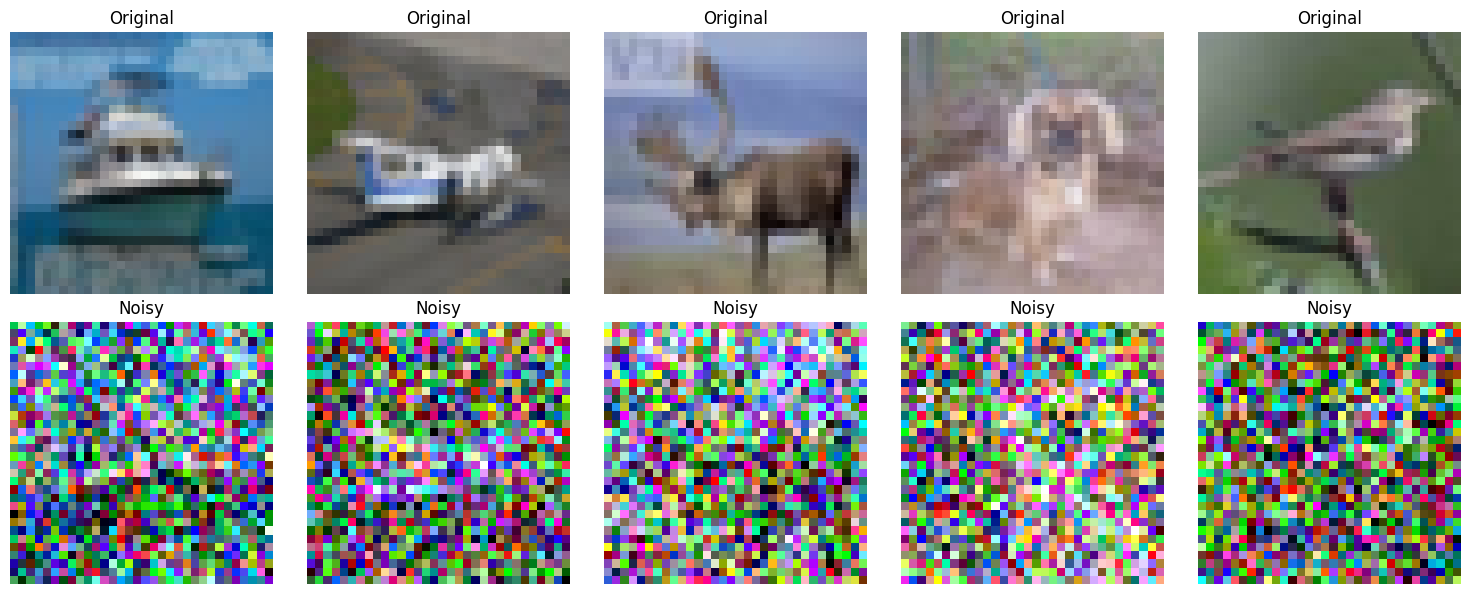

In [15]:
from utils.visualization import visualize_noisy_samples

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = 250
noisy_images, noise = diffusion.forward_diffusion(images, t)

visualize_noisy_samples(images, noisy_images, num_samples=5)

In [66]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np

def calculate_local_entropy(image, patch_size=8):
    """
    Calculate local entropy for non-overlapping patches of an image.
    
    Args:
        image (torch.Tensor): A single image tensor of shape (C, H, W).
        patch_size (int): Size of the square patches to extract.
    
    Returns:
        entropy_map (np.ndarray): A 2D array containing entropy values for each patch.
    """
    # Convert the image to a numpy array
    image = image.cpu().numpy()
    
    # Get the dimensions of the image
    C, H, W = image.shape
    
    # Calculate the number of patches in both dimensions
    num_patches_x = H // patch_size
    num_patches_y = W // patch_size
    
    entropy_map = np.zeros((num_patches_x, num_patches_y))

    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            
            patch_data = patch.flatten()
            patch_data = (patch_data - patch_data.min()) / (patch_data.max() - patch_data.min())
            
            hist, _ = np.histogram(patch_data, bins=256, range=(0, 1), density=True)
            
            patch_entropy = entropy(hist + 1e-10)  # Add a small constant to avoid log(0)
            
            entropy_map[i, j] = patch_entropy
    
    return entropy_map

def visualize_image_with_patch_entropy(image, entropy_map, patch_size=8):
    """
    Visualize the image with entropy scores for each patch.
    
    Args:
        image (torch.Tensor): The original image tensor.
        entropy_map (np.ndarray): A 2D array of entropy values for each patch.
        patch_size (int): Size of the patches.
    """
    # Convert the image to numpy and denormalize
    image = image.cpu().numpy()
    image = (image * 0.5) + 0.5  # Undo normalization
    image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    num_patches_x, num_patches_y = entropy_map.shape

    # Display the image with entropy values for each patch
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    
    # Add entropy values as text over each patch
    for i in range(num_patches_x):
        for j in range(num_patches_y):
            y_pos = (i * patch_size) + patch_size // 2
            x_pos = (j * patch_size) + patch_size // 2
            ax.text(x_pos, y_pos, f"{entropy_map[i, j]:.2f}", color='red', 
                    ha='center', va='center', fontsize=10, fontweight='bold', 
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    plt.axis('off')
    plt.show()

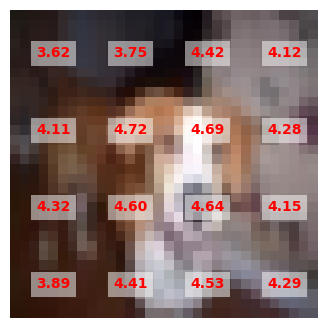

In [112]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

single_image = images[0]

patch_size = 8
entropy_map = calculate_local_entropy(single_image, patch_size=patch_size)

visualize_image_with_patch_entropy(single_image, entropy_map, patch_size=patch_size)


In [137]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

def calculate_timesteps(max_timesteps, normalized_randomness):
    return int((max_timesteps-1) / math.exp(normalized_randomness))

def apply_noise_based_on_randomness(image, diffusion, randomness_map, patch_size=8, max_timesteps=1000):
    noisy_image = image.clone()

    num_patches_x, num_patches_y = randomness_map.shape

    min_randomness = randomness_map.min()
    max_randomness = randomness_map.max()
    if max_randomness - min_randomness == 0:
        normalized_randomness = 1
    else:
        normalized_randomness = (randomness_map - min_randomness) / (max_randomness - min_randomness)

    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

            # timesteps = int((1 - normalized_randomness[i, j]) * max_timesteps)
            # timesteps = int((max_timesteps-1)/math.exp(normalized_randomness[i, j]))
            timesteps = calculate_timesteps(max_timesteps, normalized_randomness[i, j])
            # print(f"For ra {normalized_randomness[i, j]} noising with {timesteps} timesteps")

            t = torch.tensor([timesteps], device=image.device)
            noisy_patch, _ = diffusion.forward_diffusion(patch.unsqueeze(0), t)

            noisy_image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = noisy_patch.squeeze(0)

    return noisy_image

def visualize_image_with_patches(image, patch_size=8, show_borders=True):
    """
    Visualize the image with an option to display patch borders.

    Args:
        image (torch.Tensor): The input image tensor.
        patch_size (int): Size of the patches.
        show_borders (bool): Whether to show the patch borders or not.
    """
    image = image.cpu().numpy()
    image = (image * 0.5) + 0.5  # Undo normalization
    image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)

    if show_borders:
        H, W, _ = image.shape
        num_patches_x = H // patch_size
        num_patches_y = W // patch_size

        for i in range(1, num_patches_x):
            ax.axhline(i * patch_size, color='white', linestyle='--', linewidth=1)
        for j in range(1, num_patches_y):
            ax.axvline(j * patch_size, color='white', linestyle='--', linewidth=1)

    plt.axis('off')
    plt.show()

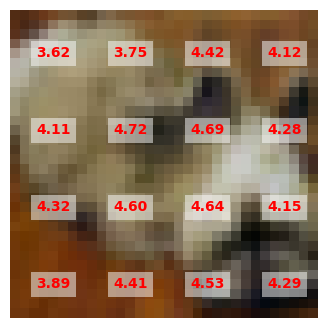

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.764025..1.2234324].


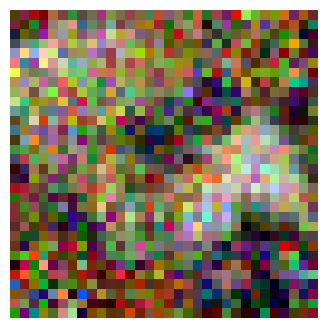

In [138]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

single_image = images[0]

patch_size = 8
randomness_map = calculate_local_entropy(single_image, patch_size=patch_size)

max_timesteps = 200
noisy_image = apply_noise_based_on_randomness(single_image, diffusion, randomness_map, patch_size=patch_size, max_timesteps=max_timesteps)

visualize_image_with_patch_entropy(single_image, entropy_map, patch_size=patch_size)
visualize_image_with_patches(noisy_image, patch_size=patch_size, show_borders=False)

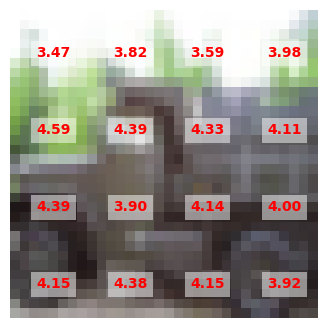

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1555005..2.4121509].


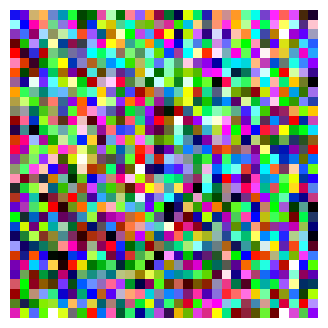

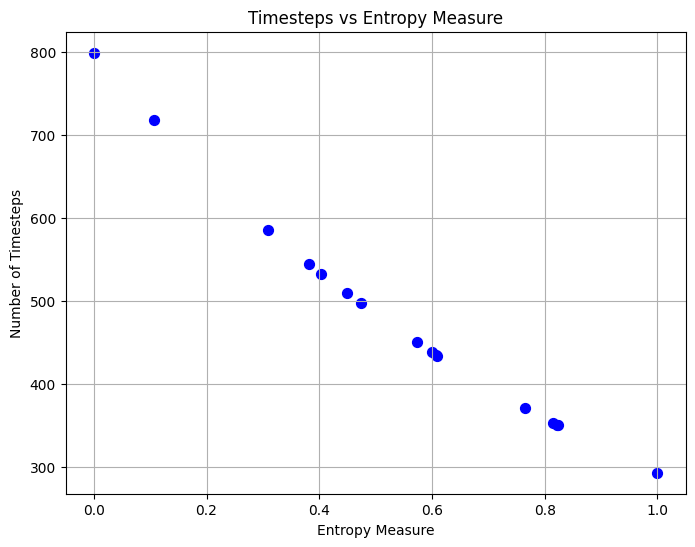

In [144]:
import matplotlib.pyplot as plt
import numpy as np

ra_timesteps_data = []

def process_and_visualize_image(image, diffusion, patch_size=8, max_timesteps=1000):
    global ra_timesteps_data

    randomness_map = calculate_local_entropy(image, patch_size=patch_size)
    noisy_image = apply_noise_based_on_randomness(image, diffusion, randomness_map, patch_size=patch_size, max_timesteps=max_timesteps)

    for i in range(randomness_map.shape[0]):
        for j in range(randomness_map.shape[1]):
            num_patches_x, num_patches_y = randomness_map.shape

            min_randomness = randomness_map.min()
            max_randomness = randomness_map.max()
            if max_randomness - min_randomness == 0:
                normalized_randomness = 1
            else:
                normalized_randomness = (randomness_map - min_randomness) / (max_randomness - min_randomness)

            ra_value = normalized_randomness[i, j].item()
            timesteps = calculate_timesteps(max_timesteps, normalized_randomness[i, j])
            ra_timesteps_data.append((ra_value, timesteps))

    visualize_image_with_patch_entropy(image, randomness_map, patch_size=patch_size)
    visualize_image_with_patches(noisy_image, patch_size=patch_size, show_borders=False)

def plot_all_timesteps_vs_randomness():
    ra_values, timestep_values = zip(*ra_timesteps_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(ra_values, timestep_values, color='blue', s=50)
    plt.title("Timesteps vs Entropy Measure")
    plt.xlabel("Entropy Measure")
    plt.ylabel("Number of Timesteps")
    plt.grid(True)
    plt.show()

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')


process_and_visualize_image(images[0], diffusion, patch_size=8, max_timesteps=800)
plot_all_timesteps_vs_randomness()